In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~ /.kaggle
! cp kaggle.json ~ /.kaggle /
! chmod 600 ~ /.kaggle / kaggle.json

In [ ]:
! kaggle datasets download -d sshikamaru / car-object-detection
! unzip car-object-detection.zip

In [5]:
import numpy as np
import torch
import torchvision
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import pandas as pd

from torch.utils.data import Dataset, DataLoader
from torch import nn

from torchvision.ops.boxes import nms

from PIL import Image

%matplotlib inline

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


 ## Test image dataframe


In [6]:
start_path = os.getcwd()
data_path = os.path.join(start_path, 'data')
classes = ['Car']

In [7]:
df = pd.read_csv(os.path.join(data_path, 'train_solution_bounding_boxes (1).csv'))

In [8]:
df.head()

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


In [9]:
df['class'] = 1
df['bboxes'] = df[['xmin', 'ymin', 'xmax', 'ymax']].apply(list, axis=1)
df = df.drop(columns=['xmin', 'ymin', 'xmax', 'ymax']).groupby('image', as_index=False).agg(list)

In [12]:
df.head()

,image,class,bboxes
0,vid_4_1000.jpg,[1],"[[281.2590449, 187.0350708, 327.7279305, 223.2..."
1,vid_4_10000.jpg,[1],"[[15.16353111, 187.0350708, 120.3299566, 236.4..."
2,vid_4_10020.jpg,[1],"[[496.4833575, 172.3632561, 630.0202605, 231.5..."
3,vid_4_10040.jpg,[1],"[[239.1924747, 176.7648005, 361.9681621, 236.4..."
4,vid_4_10060.jpg,[1],"[[16.63096961, 186.5460103, 132.5586107, 238.3..."


## Look at some train images

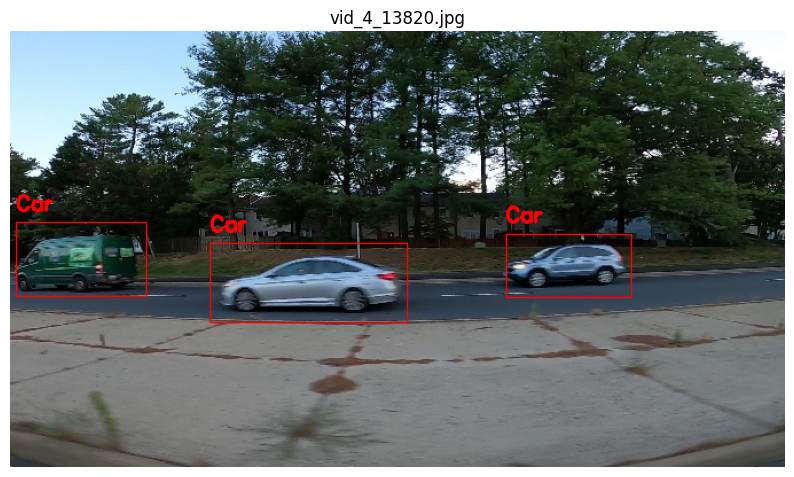

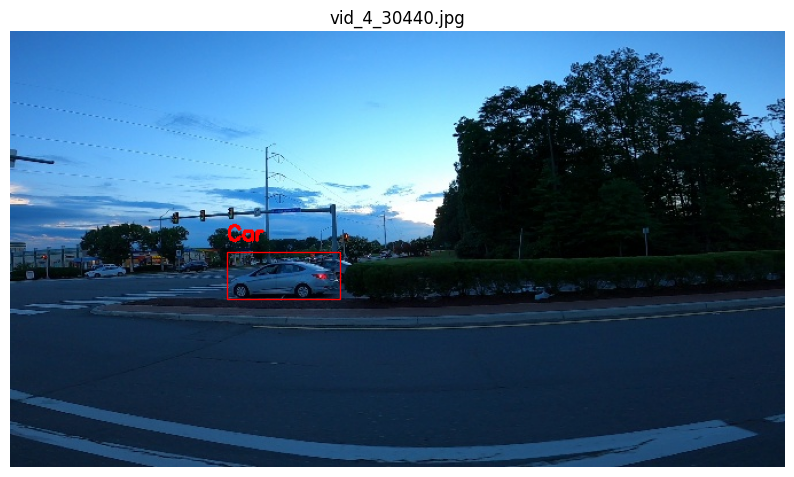

In [ ]:
from random import randint
import matplotlib.patches as patches


def draw_img_with_box(df_index):
    img = cv2.imread(os.path.join(data_path, 'training_images', df.loc[df_index, 'image']))
    img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
    fig, ax = plt.subplots(figsize=(10, 10))
    boxes = df.loc[df_index, 'bboxes']
    for bbox in boxes:
        rect = patches.Rectangle((int(bbox[0]), int(bbox[1])), int(bbox[2]) - int(bbox[0]), int(bbox[3]) - int(bbox[1]),
                                 linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        cv2.putText(img, 'Car', (int(bbox[0]), int(bbox[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
    ax.imshow(img)
    plt.title(df.loc[df_index, 'image'])
    ax.axis('off')
    plt.show()


for _ in range(2):
    draw_img_with_box(randint(0, len(df)))

## Dataset constructor

In [ ]:
class CarDataset(Dataset):

    def __init__(self, dataframe, root, transforms=None):
        self.df = dataframe
        self.img_path = root
        self.transforms = transforms

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        img_name = self.df.loc[index, 'image']
        boxes = torch.Tensor(self.df.loc[index, 'bboxes']).to(torch.float)
        labels = torch.Tensor(self.df.loc[index, 'class']).to(torch.int64)
        image_id = torch.tensor([index])

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target["image_id"] = image_id

        img = cv2.imread(os.path.join(self.img_path, img_name)) / 255.
        img = torch.from_numpy(img).permute(2, 0, 1).to(torch.float)

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

## Model creation

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


def create_fasterrcnn_model():
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')
    num_classes = 2
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.to(device)
    return model


model = create_fasterrcnn_model()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

## Separating the dataset into test and validation

In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2)

train_df.index = range(len(train_df))
val_df.index = range(len(val_df))

train_dataset = CarDataset(dataframe=train_df, root=os.path.join(data_path, 'training_images'))
val_dataset = CarDataset(dataframe=val_df, root=os.path.join(data_path, 'training_images'))

train_data_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)
val_data_loader = DataLoader(val_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

In [ ]:
if not os.path.exists(os.path.join(os.getcwd(), 'checpoints')):
    os.mkdir(os.path.join(os.getcwd(), 'checpoints'))
if not os.path.exists(os.path.join(os.getcwd(), 'checpoints', 'FasterRCNN')):
    os.mkdir(os.path.join(os.getcwd(), 'checpoints', 'FasterRCNN'))

## Training and validation functions

In [ ]:
def train_func(model, train_dataloader):
    model.train()
    running_loss = 0
    for batch_idx, data in enumerate(train_dataloader):
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        if batch_idx % 50 == 0:
            print(f'Номер батча (train): {batch_idx}, loss = {loss}')
    train_loss = running_loss / len(train_dataloader.dataset)
    return train_loss


def val_func(model, val_dataloader):
    running_loss = 0
    i = 0
    for data in val_dataloader:
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.no_grad():
            loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
        if i % 20 == 0:
            print(f'Номер батча (val): {i}, loss = {loss}')
        i += 1
    val_loss = running_loss / len(val_dataloader.dataset)
    return val_loss

## Start training

In [ ]:
from datetime import datetime


def train(model, num_epoch, train_dataloader, val_dataloader):
    train_losses = []
    val_losses = []
    try:
        start_train = datetime.now()
        print(f'Начало обучения: {start_train.strftime("%H:%M:%S")}')
        for epoch in range(1, num_epoch + 1):
            start_epoch = datetime.now()
            print(f'Начало обучения эпохи №{epoch}: {start_epoch.strftime("%H:%M:%S")}')
            train_loss = train_func(model, train_dataloader)
            val_loss = val_func(model, val_dataloader)
            scheduler.step()
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            print(
                f'Эпоха №{epoch} выполнилась за {datetime.now() - start_epoch} (Общее время обучения на данный момент: {datetime.now() - start_train}), train_loss_per_epoch = {train_loss}, val_loss_per_epoch = {val_loss}')

            # save model
            torch.save({'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(),
                        'scheduler_state_dict': scheduler.state_dict()},
                       os.path.join(data_path, f'checpoints/FasterRCNN/checpoint_(test_and_val)_epoch_{epoch}.pt'))
        print(f'Обучение выполнилось за {datetime.now() - start_train}')

    except KeyboardInterrupt:
        print('Прервано пользователем')

    return train_losses, val_losses

In [ ]:
train_losses, val_losses = train(model, 30, train_data_loader, val_data_loader)

Начало обучения: 15:40:37
Начало обучения эпохи №1: 15:40:37
Номер батча (train): 0, loss = 0.6300241351127625
Номер батча (train): 50, loss = 0.11017872393131256
Номер батча (train): 100, loss = 0.21486002206802368
Номер батча (train): 150, loss = 0.1354345828294754
Номер батча (train): 200, loss = 0.09548397362232208
Номер батча (train): 250, loss = 0.07737426459789276
Номер батча (val): 0, loss = 0.07236000150442123
Номер батча (val): 20, loss = 0.11306770145893097
Номер батча (val): 40, loss = 0.05506758391857147
Номер батча (val): 60, loss = 0.4388081133365631
Эпоха №1 выполнилась за 0:01:42.422145 (Общее время обучения на данный момент: 0:01:42.422252), train_loss_per_epoch = 0.17840171876219166, val_loss_per_epoch = 0.11165464254961886
Начало обучения эпохи №2: 15:42:21
Номер батча (train): 0, loss = 0.3017469346523285
Номер батча (train): 50, loss = 0.02986842580139637
Номер батча (train): 100, loss = 0.1015540063381195
Номер батча (train): 150, loss = 0.03850746154785156
Номер

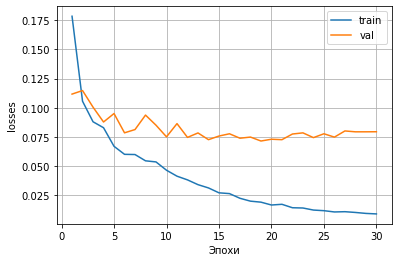

In [ ]:
def draw_train_val_res(train_losses, val_losses, num_epoch):
    x = range(1, num_epoch + 1)
    plt.plot(x, train_losses, label='train')
    plt.plot(x, val_losses, label='val')
    plt.legend()
    plt.grid()
    plt.xlabel('Эпохи')
    plt.ylabel('losses')


draw_train_val_res(train_losses, val_losses, 30)

In [ ]:
checkpoint = torch.load(
    os.path.join(os.getcwd(), 'checpoints', 'FasterRCNN', 'checpoint_(test_and_val)_epoch_30.pt'))
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## Look at some test images

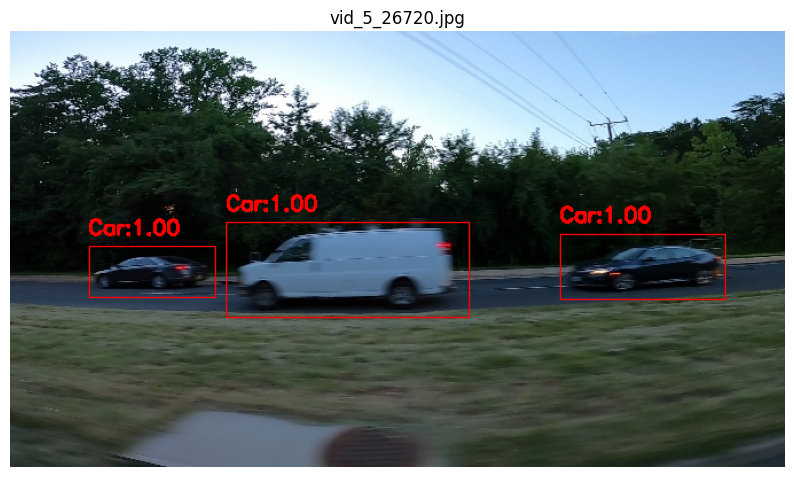

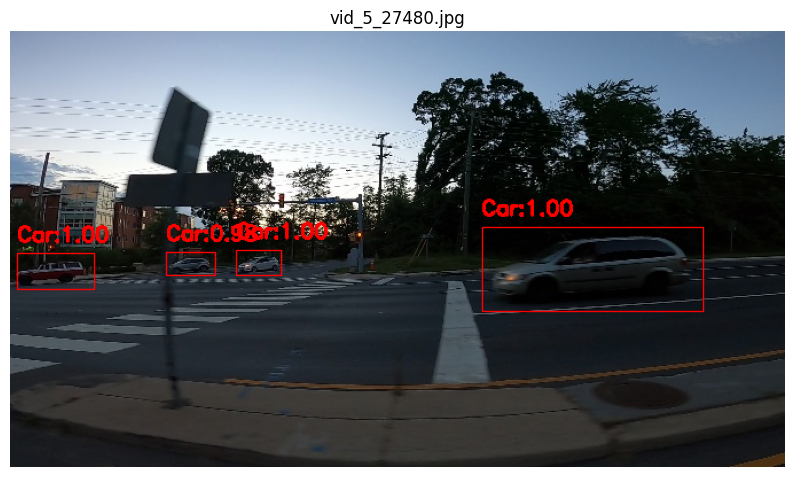

In [ ]:
from random import choice


def draw_predict(image_name, iou_threshold=0.1, threshold=0.8):
    model.eval()
    img = cv2.imread(os.path.join(data_path, 'testing_images', image_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
    img_ = img / 255.
    img_ = torch.from_numpy(img_).permute(2, 0, 1).unsqueeze(0).to(torch.float).to(device)
    predict = model(img_)
    ind = nms(predict[0]['boxes'], predict[0]['scores'], iou_threshold).detach().cpu().numpy()
    fig, ax = plt.subplots(figsize=(10, 10))
    for i, box in enumerate(predict[0]['boxes'][ind]):
        if predict[0]['scores'][i] > threshold:
            rect = patches.Rectangle((int(box[0]), int(box[1])), int(box[2]) - int(box[0]), int(box[3]) - int(box[1]),
                                     linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            cv2.putText(img, f"{classes[int(predict[0]['labels'][i]) + 1]}:{predict[0]['scores'][i]:0.2f}",
                        (int(box[0]), int(box[1]) - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
    ax.imshow(img)
    plt.title(image_name)
    ax.axis('off')


for _ in range(2):
    draw_predict(choice(os.listdir(os.path.join(data_path, 'testing_images'))))

In [18]:
def submission(iou_threshold=0.1, threshold=0.8):
    model.eval()
    image = []
    bounds = []
    list_test_images = os.listdir(os.path.join(data_path, 'testing_images'))
    for image_name in list_test_images:
        img = cv2.imread(os.path.join(data_path, 'testing_images', image_name))
        img_ = img / 255.
        img_ = torch.from_numpy(img_).permute(2, 0, 1).unsqueeze(0).to(torch.float).to(device)
        predict = model(img_)
        ind = nms(predict[0]['boxes'], predict[0]['scores'], iou_threshold).detach().cpu().numpy()
        bound = " "
        for i, box in enumerate(predict[0]['boxes'][ind]):
            if predict[0]['scores'][i] > threshold:
                bound += f"{box[0]:0.1f} {box[1]:0.1f} {box[2]:0.1f} {box[3]:0.1f}"
        # if bound.isspace():
        #     bounds.append(np.NaN)
        # else:
        #     bounds.append(bound)
        image.append(image_name)
    dataframe = pd.DataFrame({'image': image, 'bounds': bounds})
    dataframe.to_csv(os.path.join(data_path, 'submission.csv'), index=False)


submission()

In [ ]:
# def submission(iou_threshold=0.1, threshold=0.8):
#     model.eval()
#     image = []
#     bounds = []
#     list_test_images = os.listdir(os.path.join(data_path, 'testing_images'))
#     for image_name in list_test_images:
#         img = cv2.imread(os.path.join(data_path, 'testing_images', image_name))
#         img_ = img / 255.
#         img_ = torch.from_numpy(img_).permute(2, 0, 1).unsqueeze(0).to(torch.float).to(device)
#         predict = model(img_)
#         ind = nms(predict[0]['boxes'], predict[0]['scores'], iou_threshold).detach().cpu().numpy()
#         bound = " "
#         for i, box in enumerate(predict[0]['boxes'][ind]):
#             if predict[0]['scores'][i] > threshold:
#                 bound += f"{box[0]:0.1f} {box[1]:0.1f} {box[2]:0.1f} {box[3]:0.1f} "
#         if bound.isspace():
#             continue
#         bounds.append(bound)
#         image.append(image_name)
#     dataframe = pd.DataFrame({'image': image, 'bounds': bounds})
#     dataframe.to_csv(os.path.join(os.getcwd(), 'drive', 'MyDrive', 'submission_with_nan.csv'), index=False)
#
# submission()

In [29]:
test_df = pd.read_csv('C:\\Users\\123\\PycharmProjects\\Detection\\Car\\submission (5).csv')

In [30]:
test_df.head()

,image,bounds
0,vid_5_26700.jpg,300.4 185.5 428.4 235.5 573.3 152.2 674.5 239.8
1,vid_5_26740.jpg,140.7 191.4 292.7 242.8 603.9 177.6 675.1 224...
2,vid_5_26940.jpg,0.0 194.6 59.8 230.2 207.5 190.4 324.2 232.6
3,vid_5_27420.jpg,347.1 184.4 380.6 210.9 229.5 183.8 280.5 214...
4,vid_5_26600.jpg,642.3 187.1 673.8 227.1


In [31]:
j = 0
for row in test_df['bounds']:
    bbox = []
    bboxes = []
    i = 0
    for num in row.split():
        bbox.append(float(num))
        i += 1
        if i == 4:
            i = 0
            bboxes.append(bbox)
            bbox = []
    test_df.iloc[j]['bounds'] = bboxes
    j += 1

In [32]:
test_df.head()

,image,bounds
0,vid_5_26700.jpg,"[[300.4, 185.5, 428.4, 235.5], [573.3, 152.2, ..."
1,vid_5_26740.jpg,"[[140.7, 191.4, 292.7, 242.8], [603.9, 177.6, ..."
2,vid_5_26940.jpg,"[[0.0, 194.6, 59.8, 230.2], [207.5, 190.4, 324..."
3,vid_5_27420.jpg,"[[347.1, 184.4, 380.6, 210.9], [229.5, 183.8, ..."
4,vid_5_26600.jpg,"[[642.3, 187.1, 673.8, 227.1]]"


In [27]:
def save_draw_predict(df_index):
    img = cv2.imread(os.path.join(os.getcwd(), 'testing_images', test_df.loc[df_index, 'image']))
    boxes = test_df.loc[df_index, 'bounds']
    for bbox in boxes:
        cv2.rectangle(img, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (255, 0, 0), 1)
    cv2.imwrite(os.path.join(os.getcwd(), 'testing_img_with_bbox', test_df.loc[df_index, 'image']), img)


for i in range(len(test_df)):
    save_draw_predict(i)